In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = os.path.join(Path().absolute().parent)
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_noisy', 'synth_falfa_nn_db.csv'))
print(df.shape)

(4050, 38)


In [5]:
noise_rate = df['Data'].apply(lambda x: float(x.split('_')[6][2:]))
df['Noise.Rate'] = noise_rate

In [6]:
print(df.columns)

Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base', 'Noise.Rate'],
      dtype='object')


In [7]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
COL_Y = 'Test.Poison'

print(len(COLS_CM))

28


In [8]:
N_ITER_SEARCH = 100

# Find parameter
param = {'alpha': loguniform(1e-4, 10),}
X = df[COLS_CM]
y = df[COL_Y]
regressor = linear_model.Ridge()
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(X, y)

best_estimator_ = param_search.best_estimator_.get_params()
alpha = np.round(best_estimator_['alpha'], 4)
print(alpha)

0.0066


In [9]:
N_FOLD = 5

df['Prediction'] = 0.

# Split by clean data
idx_clean = df[df['Rate'] == 0].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
for i_train, i_test in kf.split(idx_clean):
    idx_train_clean = idx_clean[i_train]
    idx_test_clean = idx_clean[i_test]

    data_train = df.loc[idx_train_clean, 'Data.Base']
    data_test = df.loc[idx_test_clean, 'Data.Base']

    idx_train = df[df['Data.Base'].isin(data_train)].index
    idx_test = df[df['Data.Base'].isin(data_test)].index
    print(f'Train: {len(idx_train)} Test: {len(idx_test)}')
    assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

    X_train = df.loc[idx_train, COLS_CM]
    y_train = df.loc[idx_train, COL_Y]
    X_test = df.loc[idx_test, COLS_CM]
    y_test = df.loc[idx_test, COL_Y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

# Apply clipping
df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

Train: 3240 Test: 810
Train: 3240 Test: 810
Train: 3240 Test: 810
Train: 3240 Test: 810
Train: 3240 Test: 810


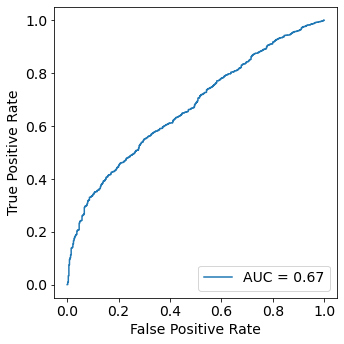

In [10]:
THRESHOLD = 0.0

FONTSIZE = 14
FIGSIZE = (5, 5)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
y_true_ = (df['Rate'] > THRESHOLD).astype(int)
y_score_ = df['Train.Poison'] - df['Prediction']
fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
roc_auc_ = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_).plot(ax=ax)
plt.tight_layout()
plt.show()


In [11]:
df_ = df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)]
dif_00 = (df_['Train.Poison'] - df_['Prediction'])
print(dif_00.min(), dif_00.max())

threshold = np.quantile(dif_00, 0.95)

print(f'threshold: {threshold}')

-0.00347222222222221 0.851184369670948
threshold: 0.38590274792825896


In [12]:
df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)].shape[0]

50

In [13]:
results = (df['Train.Poison'] - df['Prediction']) > threshold
df_ = df[['Noise.Rate', 'Rate']].copy()
df_['Prediction'] = results.astype(int)
df_ = df_.rename(columns = {'Noise.Rate':'Noise Label Rate', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
df_grouped = df_.groupby(['Noise Label Rate', 'Poisoning Rate']).sum()
df_grouped = df_grouped.reset_index()
df_pivot = df_grouped.pivot('Poisoning Rate', 'Noise Label Rate', 'FPR')
df_pivot

Noise Label Rate,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40
Poisoning Rate,,,,,,,,,
0.00,3,3,8,11,13,17,19,24,24
0.05,7,6,10,13,17,20,19,24,23
0.10,16,19,21,21,24,24,25,24,29
0.15,15,21,23,27,24,28,27,28,28
0.20,26,26,25,26,30,27,27,27,27
0.25,23,26,26,28,32,31,32,28,31
0.30,26,28,30,32,32,33,27,34,31
0.35,23,22,28,26,30,28,34,28,28
0.40,25,23,28,28,30,25,30,30,29


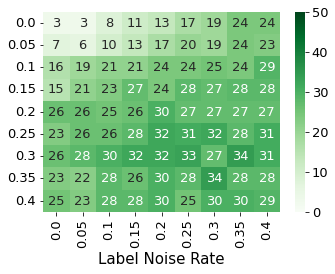

In [14]:
FONTSIZE = 13
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.heatmap(df_pivot, ax=ax, annot=True, fmt='d', cmap="Greens", vmin=0, vmax=50)
plt.yticks(rotation=0)
plt.xlabel('Label Noise Rate', fontsize=FONTSIZE+2)
# plt.ylabel('Poisoning Rate', fontsize=FONTSIZE+2)
plt.ylabel('')
plt.tight_layout()
# plot_output = os.path.join(path_output, 'synth_heatmap_noise.svg')
# plt.savefig(plot_output, dpi=300)
plt.show()